# Diabetic Retinopathy Workspace

## Setup gdrive files

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cd /content

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from keras.datasets import cifar10
from keras.datasets import mnist
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [0]:
dir_path =  '/content/gdrive/My Drive/BME_Project_3_LCA_viz/data/'

In [0]:
#Diabetic Retinopathy Data:

df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))

In [0]:
def append_ext(fn):
    return fn+".png"

df_train["id_code"]= df_train["id_code"].apply(append_ext)

In [0]:
#For some reason the generator wants diagnostic labels in string form:

df_train['diagnosis'] = df_train['diagnosis'].astype(str)

In [0]:
SEED = 7
np.random.seed(SEED)
set_random_seed(SEED)
dir_path =  '/content/gdrive/My Drive/BME_Project_3_LCA_viz/data/'
IMG_DIM = 299  # 224 399 #
BATCH_SIZE = 1000
CHANNEL_SIZE = 3
NUM_EPOCHS = 10
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    validation_split=0.20)

In [0]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= dir_path+TRAIN_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="sparse",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=SEED,
                                                    )

Found 2930 validated image filenames belonging to 5 classes.


In [0]:
#Take batch index 0, with size = BATCH_SIZE (set above)
x_train, y_train = train_generator[0]

In [0]:
x_train.shape

(1000, 299, 299, 3)

In [0]:
vector_size = x_train.shape[1]*x_train.shape[2]*x_train.shape[3]
x_train = x_train.reshape(x_train.shape[0], vector_size)

In [0]:
num_classes = 5
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

## MNIST VERSION DATA

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

vector_size = x_train.shape[1]*x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], vector_size)
x_test = x_test.reshape(x_test.shape[0], vector_size)

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Run LCA on Model

In [0]:
def calculate_LCA(grads, current_weights, old_weights):
    LCA = grads*(current_weights - old_weights)
    return LCA

In [0]:
gradient1 = []
gradient2 = []
gradient_out = []
weights1 = []
weights2 = []
weights_out = []
all_loss = []
LCA_1 = []
LCA_2 = []
LCA_out = []
hidden_nodes = 25
#x = tf.placeholder(shape=[None, vector_size], dtype=tf.float32, name='x')
#y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name='y')

X = tf.placeholder("float", [None, vector_size])
Y = tf.placeholder("float", [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

weights = {
    'w1': tf.Variable(tf.truncated_normal([vector_size, hidden_nodes], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([hidden_nodes, num_classes], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[hidden_nodes])),
    'b2': tf.Variable(tf.constant(0.1, shape=[hidden_nodes])),
    'out': tf.Variable(tf.constant(0.1, shape=[num_classes]))
}


layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_drop = tf.nn.dropout(layer_2, keep_prob)
output_layer = tf.matmul(layer_2, weights['out']) + biases['out']

#a1 = tf.nn.relu(tf.matmul(x, w1))
#y_est = tf.nn.softmax(tf.matmul(a1, w2))

#loss = tf.keras.losses.categorical_crossentropy(Y, output_layer)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=Y, logits=output_layer
        ))

optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(loss)

#optimizer = tf.train.GradientDescentOptimizer(0.005)
(_, grads1), (_, grads2), (_, grads_out) = optimizer.compute_gradients(loss, [weights['w1'], weights['w2'], weights['out']])

#train = optimizer.minimize(loss)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=Y))

correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
#print('Layer 1', sess.run(tf.shape(layer_1)))

iters = 50
for i in range(iters):
    _, _, _, _, _, _, current_loss, current_acc, _ = sess.run([grads1, grads2, grads_out, weights['w1'], weights['w2'],weights['out'],
                                                            loss, accuracy, train], feed_dict={X: x_train, Y: y_train})
    variables = tf.trainable_variables()
    #print(variables)
    weights1.append(sess.run(weights['w1']))
    weights2.append(sess.run(weights['w2']))
    weights_out.append(sess.run(weights['out']))
    layer1_grad = sess.run(grads1, feed_dict={X: x_train, Y: y_train})
    layer2_grad = sess.run(grads2, feed_dict={X: x_train, Y: y_train})
    layer_out_grad = sess.run(grads_out, feed_dict={X: x_train, Y: y_train})
    all_loss.append(sess.run(loss, feed_dict={X: x_train, Y: y_train}))
    gradient1.append(layer1_grad)
    gradient2.append(layer2_grad)
    gradient_out.append(layer_out_grad)
    if i > 0:
      #LCA_array[i] = calculate_LCA(gradient1[i], weights1[i], weights1[i-1])
      LCA_1.append(calculate_LCA(gradient1[i], weights1[i], weights1[i-1]))
      LCA_2.append(calculate_LCA(gradient2[i], weights2[i], weights2[i-1])) 
      LCA_out.append(calculate_LCA(gradient_out[i], weights_out[i], weights_out[i-1]))     
    print(current_acc)
    print(current_loss)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

0.096
3.3946958
0.097
6543.6167
0.493
16085.392
0.051
15099.638
0.097
51812.406
0.282
8084.799
0.493
18617.217
0.051
29295.162
0.103
4408.081
0.283
5326.025
0.49
5220.135
0.225
8786.101
0.487
3902.519
0.459
5117.2617
0.513
3944.2603
0.647
3838.3665
0.483
3072.035
0.479
2760.9468
0.517
1440.6847
0.566
2058.4688
0.64
1655.6273
0.269
2998.9004
0.571
1650.1627
0.605
1779.2444
0.672
1680.8922
0.53
1475.9921
0.55
1841.6543
0.537
1731.6431
0.634
958.76636
0.569
1576.1854
0.658
1162.8025
0.664
1417.8646
0.226
2719.0312
0.609
2397.811
0.624
3538.6191
0.683
3619.17
0.679
2039.8838
0.48
2943.2192
0.442
4045.0774
0.6
1801.7711
0.691
3273.136
0.688
3566.535
0.7
2822.5042
0.687
1563.8925
0.574
1914.

##Plotting Functions

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import h5py
import os
import math
import time
from scipy import stats
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter1d
from scipy.stats import dweibull
from ast import literal_eval


######################################## helpers ########################################

# concatenate arrays from multiple gpus (different keys in the same file)
def concat_arrays(hf, keyroot):
    grads = np.array(hf['{}_0'.format(keyroot)])
    for i in range(1, 4):
        nextkey = '{}_{}'.format(keyroot, i)
        if nextkey in hf.keys():
            grads = np.concatenate((grads, hf[nextkey][1:]))
    return grads

# return loss curve based on starting loss and the LCA totals
def get_approx_loss(loss, helped):
    return loss[0] + np.concatenate((np.array([0]), np.cumsum(helped.sum(axis=1))))
    
def get_approx_loss_2(loss, helped):
    return loss[0] + helped.sum(axis=1)
# e.g. [1, 4, 2, 4, 1] for num_splits = 4

def get_rk_coeffs(num_splits):
    coeffs = np.ones(num_splits + 1)
    coeffs[1::2] = 4
    coeffs[2:-1:2] = 2
    return coeffs

def get_lca_rk_adaptive(weights, gradients, splits_per_iter):
    helped = np.zeros((weights.shape[0] - 1, weights.shape[1]))
    coeffs = {}
    for i in [2, 4, 8, 16, 32]:
        coeffs[i] = get_rk_coeffs(i)

    grads_ind = 0
    for ts in range(weights.shape[0] - 1):
        num_splits = splits_per_iter[ts]
        split_gradients = gradients[grads_ind:grads_ind + num_splits + 1]
        grads_ind += num_splits
        k = np.matmul(coeffs[num_splits], split_gradients) / coeffs[num_splits].sum()
        helped[ts] = np.multiply(k, weights[ts + 1] - weights[ts])
    return helped

# returns list of variables as np arrays in their original shape
def split_and_shape(one_time_slice, shapes):
    variables = []
    offset = 0
    for shape in shapes:
        num_params = np.prod(shape)
        variables.append(one_time_slice[offset : offset + num_params].reshape(shape))
        offset += num_params
    return variables

# get neurons, given either a 2d fc layer or a 4d conv layer
def get_neurons(layer):
    return np.sum(layer, axis=tuple(range(len(layer.shape) - 1)))

# This assumes all layers have a bias layer immediately after it
# returns list. each element is a vector
def get_neurons_plus_biases(split_vars):  # flattened and joined
    layers = []
    for i in range(int(len(split_vars)/2)):
        layers.append(get_neurons(split_vars[2*i]) + split_vars[2*i + 1].flatten())
    return layers

# generate for each layer (in a list) a N x T matrix where T = total iterations, N = number of neurons
def get_neuron_trajs_all_layers(helped, shapes):
    neuron_trajs = get_neurons_plus_biases(split_and_shape(helped[0], shapes))
    for i, layer in enumerate(neuron_trajs):
        neuron_trajs[i] = layer.reshape(-1, 1)
    for ts in range(1, helped.shape[0]):
        curneurons = get_neurons_plus_biases(split_and_shape(helped[ts], shapes))
        for i in range(len(neuron_trajs)):
            neuron_trajs[i] = np.concatenate((neuron_trajs[i], curneurons[i].reshape(-1, 1)), axis=1)
    return neuron_trajs

def save_or_show(plot_dest):
    '''Save figure or show it. Allowable destinations and actions:
    Instance of PdfPages: write page to pdf
    String like "/home/user/results/foo": write /home/user/results/foo.pdf and /home/user/results/foo.png
    None: display instead of writing.
    '''
    if isinstance(plot_dest, PdfPages):
        plot_dest.savefig()
        plt.close()
    elif isinstance(plot_dest, str):
        plt.savefig('%s.png' % plot_dest)
        plt.savefig('%s.pdf' % plot_dest)
        plt.close()
    elif plot_dest is None:
        plt.show()
    else:
        raise Exception('Not sure what to do with this plot destination: %s' % repr(plot_dest))

######################################## plotters for notebooks ########################################

# plots approx loss based on rk4, returns diff per iter
def plot_approx_loss(loss, helped, plot_dest=None):
    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.plot(np.array(loss), label='actual loss')
    approx_loss = np.array(get_approx_loss(loss, helped))
    ax1.plot(approx_loss, label='sum approx loss')
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss')
    ax1.legend()

    relative_err = abs(((approx_loss[-1] - approx_loss[0]) - (loss[-1] - loss[0])) / (loss[-1] - loss[0]))

    diff = np.array(loss[:len(approx_loss)]) - approx_loss
    diff_per_iter = [diff[i+1] - diff[i] for i in range(len(diff) - 1)]
    ax2 = ax1.twinx()
    ax2.plot(diff_per_iter, 'C1', alpha=0.5, linewidth=0.5, marker='.', markersize=1)
    ax2.set_ylabel('diff per iteration')
    plt.title('true and approximated loss (err %.2f%%)' % (relative_err * 100))
    save_or_show(plot_dest)
    if not plot_dest:
        plt.hist(diff_per_iter, bins=50)
        plt.show()
        print(np.std(diff_per_iter))

    return np.array(diff_per_iter)

# kinda a subset of save_layer_train_test below...
# plots total helped per kernel layer and all layers
def plot_total_layers(total_helped, names, shapes, plot_dest=None):
    layer_indices = np.append(0, np.cumsum([np.prod(shape) for shape in shapes]))
    total_kernels = []
    total_all = []
    for i, name in enumerate(names):
        startind, endind = layer_indices[i], layer_indices[i+1]
        layer_total = total_helped[startind:endind].sum()
        total_all.append(layer_total)
        if not ('batch_norm' in name or 'bias' in name):
            total_kernels.append(layer_total)
    print('Bias and batch norm layers helped {} percent of total'.format(
        100 * (1 - np.sum(total_kernels) / np.sum(total_all))))

    # TODO make nice stacked chart over time
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(total_kernels)), total_kernels)
    plt.axhline(0, c='k', linestyle=':')
    plt.title('Kernel layers')
    plt.xlabel('Layer')
    plt.ylabel('LCA per layer')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(total_all)), total_all)
    plt.axhline(0, c='k', linestyle=':')
    plt.title('All layers')
    plt.xlabel('Layer')
    plt.ylabel('LCA per layer')
    save_or_show(plot_dest)

def plot_total_layers_revised(lca_1, lca_2, lca_out, plot_dest=None):
    #layer_indices = np.append(0, np.cumsum([np.prod(shape) for shape in shapes]))
    total_kernels = []
    total_all = []
    for name in [lca_1, lca_2, lca_out]:
        #startind, endind = layer_indices[i], layer_indices[i+1]
        layer_total = name.sum()
        total_all.append(layer_total)
        if not ('batch_norm' in name or 'bias' in name):
            total_kernels.append(layer_total)

    # TODO make nice stacked chart over time
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(total_kernels)), total_kernels)
    plt.axhline(0, c='k', linestyle=':')
    plt.title('Kernel layers')
    plt.xlabel('Layer')
    plt.ylabel('LCA per layer')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(total_all)), total_all)
    plt.axhline(0, c='k', linestyle=':')
    plt.title('All layers')
    plt.xlabel('Layer')
    plt.ylabel('LCA per layer')
    save_or_show(plot_dest)

def percent_helped_histograms(helped, plot_dest=None):
    # histogram of how many params helped, over each iteration
    negatives = helped < 0
    params_per_iter = negatives.sum(axis=1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.hist(params_per_iter)
    plt.xlabel('params helped per iteration')
    plt.ylabel('number of iterations')
    plt.title('Mean = {:.2f}, stdev = {:.2f}'.format(params_per_iter.mean(), params_per_iter.std()))

    # histogram of how many iters helped, over each parameter
    iters_per_param = negatives.sum(axis=0)
    plt.subplot(1, 2, 2)
    plt.hist(iters_per_param, bins=50)
    plt.xlabel('iterations helped per param')
    plt.ylabel('number of params')
    plt.title('Mean = {:.2f}, stdev = {:.2f}'.format(iters_per_param.mean(), iters_per_param.std()))
    save_or_show(plot_dest)
    plt.show()

def percent_helped_histograms_revised(helped, shape, plot_dest=None):
    # histogram of how many params helped, over each iteration
    negatives = helped < 0
    params_per_iter = negatives.sum(axis=2)
    params_per_iter_total = params_per_iter.sum(axis=1)
    params_percent = (params_per_iter_total / shape) * 100
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.hist(params_percent)
    plt.xlabel('percent of params helped per iteration')
    plt.ylabel('number of iterations')
    plt.title('Mean = {:.2f}, stdev = {:.2f}'.format(params_percent.mean(), params_percent.std()))

    # histogram of how many iters helped, over each parameter
    iters_per_param = negatives.sum(axis=2)
    iters_per_param_total = iters_per_param.sum(axis=0)
    iters_percent = (iters_per_param_total / 49)   
    plt.subplot(1, 2, 2)
    plt.hist(iters_percent)
    plt.xlabel('percent of iterations helped per param')
    plt.ylabel('number of params')
    plt.title('Mean = {:.2f}, stdev = {:.2f}'.format(iters_percent.mean(), iters_percent.std()))
    save_or_show(plot_dest)
    plt.show()
    
# helped train and test trajectories (cumulative) for each layer
def plot_trajectory_per_layer(helped, names, shapes, helped_test=None, layer_inds=[], iters=-1, plot_dest=None):
    if iters == -1:
        iters = helped.shape[0]
    if len(layer_inds) == 0:
        layer_inds = range(len(names))
    layer_indices = np.append(0, np.cumsum([np.prod(shape) for shape in shapes]))
    for i, name in enumerate(names):
        if i not in layer_inds:
            continue
        startind, endind = layer_indices[i], layer_indices[i+1]
        traj = np.cumsum(helped[:, startind:endind].sum(axis=1))
        plt.plot(traj[:iters])

        print(name, np.argsort(traj)[:10])
        if helped_test:
            plt.plot(np.cumsum(helped_test[:iters, startind:endind].sum(axis=1))) # can also plot overfit here instead

        plt.axhline(0, c='k', linestyle=':')
        plt.xlabel('iterations')
        plt.ylabel('LCA, summed over parameters')
        plt.title(name)
        if isinstance(plot_dest, str):
            save_or_show('%s_%02d' % (plot_dest, i))
        else:
            save_or_show(plot_dest)

def plot_trajectory_per_layer_revised(lca_1, lca_2, lca_out, helped_test=None, layer_inds=[], iters=49, plot_dest=None):
    iters = iters
    layers = ['Layer 0', 'Layer 1', 'Layer 2']
    i = 0
    # if len(layer_inds) == 0:
    #     layer_inds = range(len(names))
    # layer_indices = np.append(0, np.cumsum([np.prod(shape) for shape in shapes]))
    for name in [lca_1, lca_2, lca_out]:
        #startind, endind = layer_indices[i], layer_indices[i+1]
        traj = np.cumsum(name.sum(axis=1))
        plt.plot(traj[:iters])

        #print(name, np.argsort(traj)[:10])
        if helped_test:
            plt.plot(np.cumsum(helped_test[:iters, startind:endind].sum(axis=1))) # can also plot overfit here instead

        plt.axhline(0, c='k', linestyle=':')
        plt.xlabel('iterations')
        plt.ylabel('LCA, summed over parameters')
        plt.title(layers[i])
        if isinstance(plot_dest, str):
            save_or_show('%s_%02d' % (plot_dest, i))
        else:
            save_or_show(plot_dest)
        i += 1

# plot how much each neuron helped, each iteration. Large 2d plot for each layer
def plot_neurons_all_time(neuron_trajs, names, color_percentile=99, plot_dest=None):
    # custom color map matching the green and red used in other plots
    # red is negative and green is positive because default colormaps are like that
    cdict = {'red':   [[0.0,  0.4, 0.4],
                       [0.4,  1.0, 1.0],
                       [0.5,  1.0, 1.0],
                       [1.0,  0.0, 0.0]],
             'green': [[0.0,  0.0, 0.0],
                       [0.5,  1.0, 1.0],
                       [0.6,  1.0, 1.0],
                       [1.0,  0.3, 0.3]],
             'blue':  [[0.0,  0.0, 0.0],
                       [0.5,  1.0, 1.0],
                       [1.0,  0.0, 0.0]]}
    custom_cmap = LinearSegmentedColormap('lc', segmentdata=cdict) # previously used PiYG

    for i, layer in enumerate(neuron_trajs):
        #if 'batch_norm' in names[2 * i]:
        #    continue
        fig_height = min(3 + int(layer.shape[0] / 20), 15)
        plt.figure(figsize=(15, fig_height))
        cmap_range = np.percentile(np.absolute(layer), color_percentile)
        # sorted_layer = sorted(list(layer.T), key=lambda x: np.average(np.arange(len(x)), weights=np.abs(x)))
        plt.imshow(-layer, cmap=custom_cmap, vmin=-cmap_range, vmax=cmap_range, aspect='auto')
        plt.xlabel('iterations')
        plt.ylabel('neurons')
        plt.title(names[2 * i])
        if isinstance(plot_dest, str):
            save_or_show('%s_%02d' % (plot_dest, i))
        else:
            save_or_show(plot_dest)
def plot_neurons_all_time_revised(lca_per_neuron, color_percentile=99, plot_dest=None):
    cdict = {'red':   [[0.0,  0.4, 0.4],
                        [0.4,  1.0, 1.0],
                        [0.5,  1.0, 1.0],
                        [1.0,  0.0, 0.0]],
              'green': [[0.0,  0.0, 0.0],
                        [0.5,  1.0, 1.0],
                        [0.6,  1.0, 1.0],
                        [1.0,  0.3, 0.3]],
              'blue':  [[0.0,  0.0, 0.0],
                        [0.5,  1.0, 1.0],
                        [1.0,  0.0, 0.0]]}
    custom_cmap = LinearSegmentedColormap('lc', segmentdata=cdict) # previously used PiYG

    fig, ax = plt.subplots(figsize=(50,30))
    plt.xlabel('iterations')
    plt.ylabel('neurons')
    min_val, max_val = 0, 25

    ax.matshow(lca_per_neuron.T, cmap=custom_cmap)
    if isinstance(plot_dest, str):
        save_or_show('%s_%02d' % (plot_dest, i))
    else:
        save_or_show(plot_dest)
        
def plot_trajectories_per_layer(helped, shapes, names, plot_dest=None):
    offset = 0
    for i, shape in enumerate(shapes):
        # layer shape is (iteration, all params in layer flattened)
        num_params = np.prod(shape)
        layer = helped[:, offset : offset + num_params].cumsum(axis=0)
        offset += num_params

        bestinds = np.argsort(layer[-1])[:50]
        randinds = np.random.choice(layer.shape[1], size=min(50, layer.shape[1]), replace=False)
        best_trajs = layer[:, bestinds].T
        rand_trajs = layer[:, randinds].T
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        for j, traj in enumerate(best_trajs):
            plt.plot(np.concatenate((np.array([0]), traj)), alpha=0.5) # label=bestinds[j])
        plt.xlabel('iterations')
        plt.ylabel('cumulative helped')
        plt.subplot(1, 2, 2)
        for j, traj in enumerate(rand_trajs):
            plt.plot(np.concatenate((np.array([0]), traj)), alpha=0.5)
        plt.xlabel('iterations')
        plt.ylabel('cumulative helped')
        plt.suptitle(names[i])
        #plt.tight_layout()
        if isinstance(plot_dest, str):
            save_or_show('%s_%02d' % (plot_dest, i))
        else:
            save_or_show(plot_dest)

def plot_trajectories_per_layer_revised(lca_1, lca_2, lca_out, plot_dest=None):
    layers = ['Layer 0', 'Layer 1', 'Layer 2']   
    i = 0
    for lca in [lca_1, lca_2, lca_out]:
      # layer shape is (iteration, all params in layer flattened)
      layer = lca.cumsum(axis=0).sum(axis=1)
      bestinds = np.argsort(layer[-1])[:5]
      randinds = np.random.choice(layer.shape[1], size=min(5, layer.shape[1]), replace=False)
      best_trajs = layer[:, bestinds].T
      rand_trajs = layer[:, randinds].T
      plt.figure(figsize=(20, 10))
      plt.subplot(1, 2, 1)
      plt.title('Top 5 Contributing Neurons')
      for j, traj in enumerate(best_trajs):
          plt.plot(traj, alpha=0.5) # label=bestinds[j])
      plt.xlabel('iterations')
      plt.ylabel('cumulative LCA')
      plt.ylim(0, np.max(rand_trajs))
      plt.subplot(1, 2, 2)
      plt.title('Random 5 Contributing Neurons')
      for j, traj in enumerate(rand_trajs):
          plt.plot(np.concatenate((np.array([0]), traj)), alpha=0.5)
      plt.xlabel('iterations')
      plt.ylabel('cumulative LCA')
      plt.ylim(0, np.max(rand_trajs))
      plt.suptitle(layers[i])
      i += 1
      plt.tight_layout()
      if isinstance(plot_dest, str):
          save_or_show('%s_%02d' % (plot_dest, i))
      else:
          save_or_show(plot_dest)

## Plots

In [0]:
lca_1 = np.array(LCA_1)
lca_2 = np.array(LCA_2)
lca_out = np.array(LCA_out)

In [0]:
lca_1.shape

(49, 268203, 25)

In [0]:
lca_2.shape

(49, 25, 25)

In [0]:
lca_out.shape

(49, 25, 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


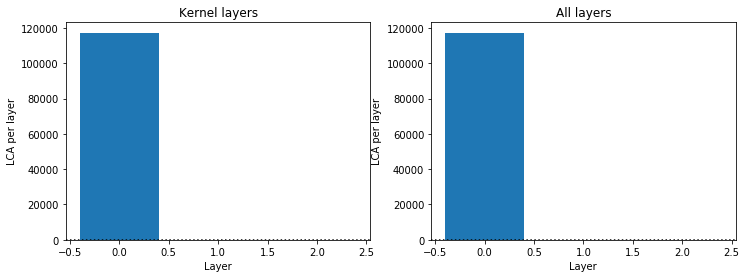

In [0]:
plot_total_layers_revised(lca_1, lca_2, lca_out)

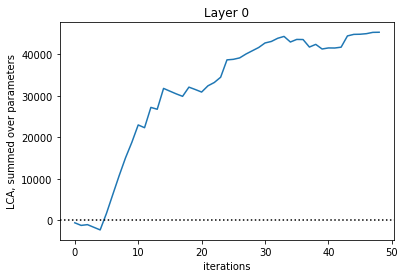

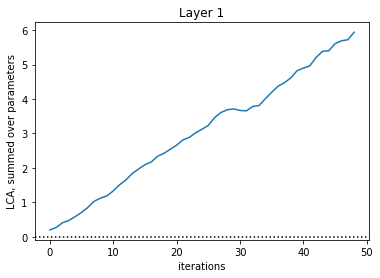

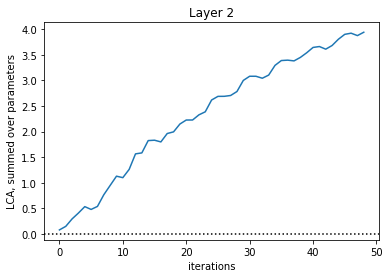

In [0]:
plot_trajectory_per_layer_revised(lca_1, lca_2, lca_out)

In [0]:
# LCA per neuron
lca_per_neuron_1 = np.zeros((49,25))
i = 0
for lca in LCA_1:
  lca_per_neuron_1[i] = np.sum(lca, axis=tuple(range(len(lca.shape) - 1)))
  i += 1
lca_per_neuron_1

lca_per_neuron_2 = np.zeros((49,25))
i = 0
for lca in LCA_2:
  lca_per_neuron_2[i] = np.sum(lca, axis=tuple(range(len(lca.shape) - 1)))
  i += 1

lca_per_neuron_out = np.zeros((49,5))
i = 0
for lca in LCA_out:
  lca_per_neuron_out[i] = np.sum(lca, axis=tuple(range(len(lca.shape) - 1)))
  i += 1

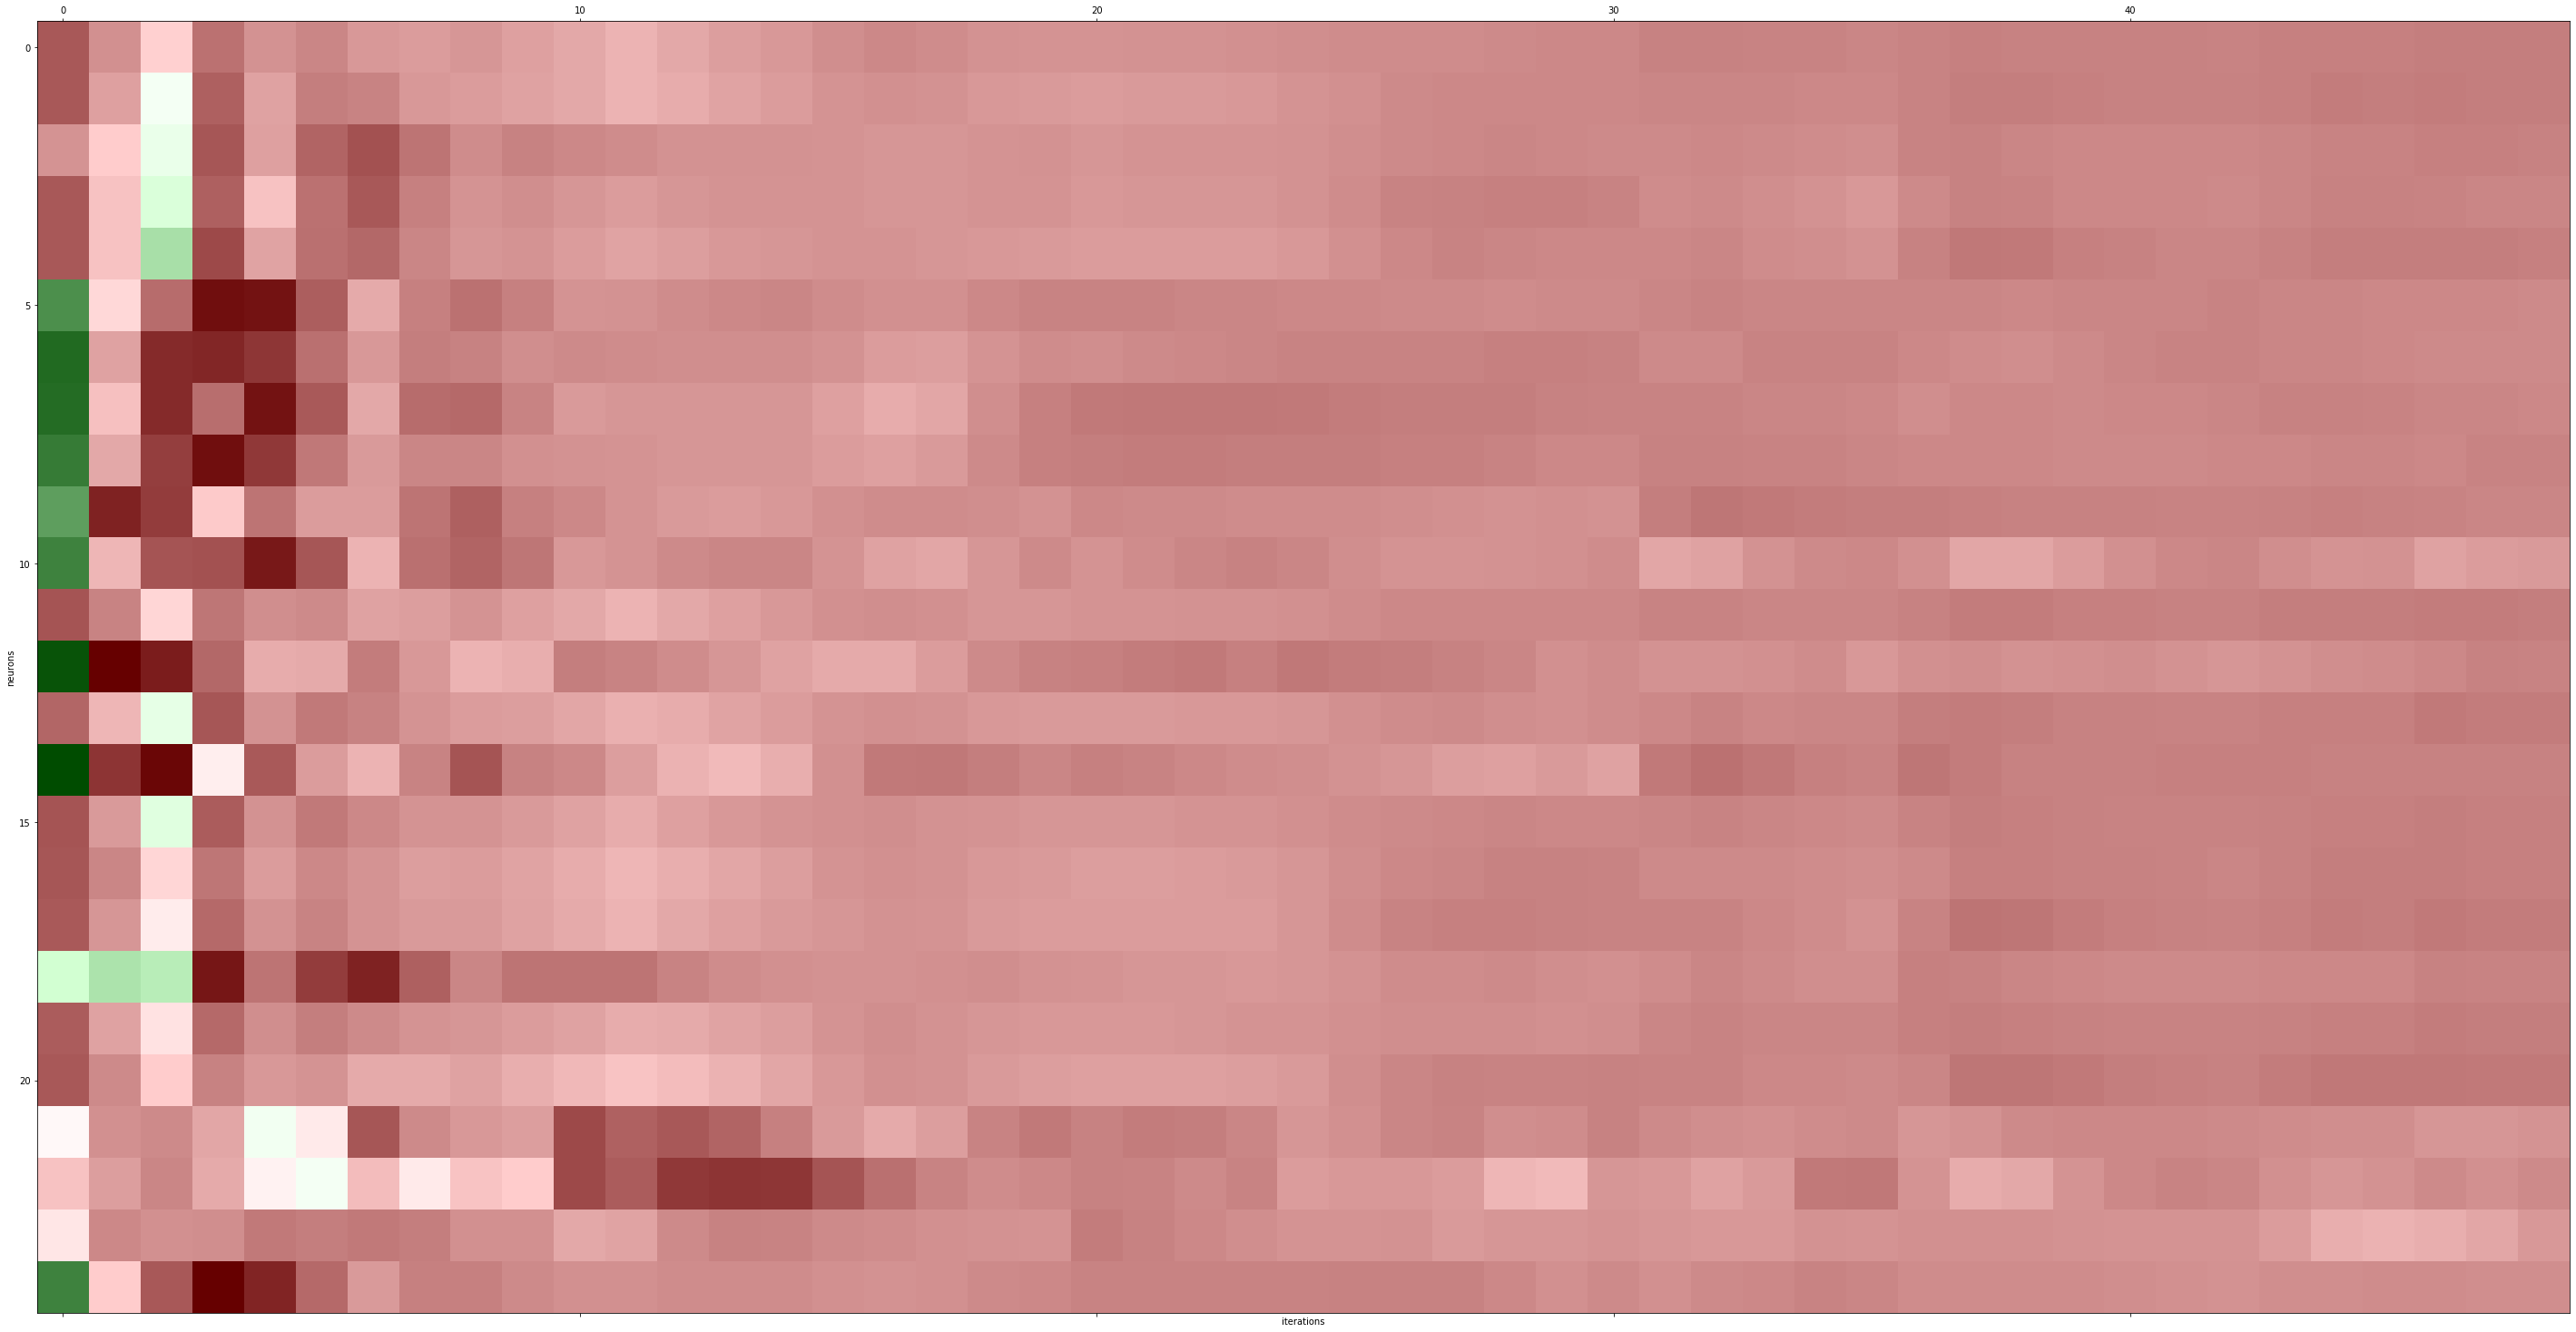

In [0]:
plot_neurons_all_time_revised(lca_per_neuron_1)

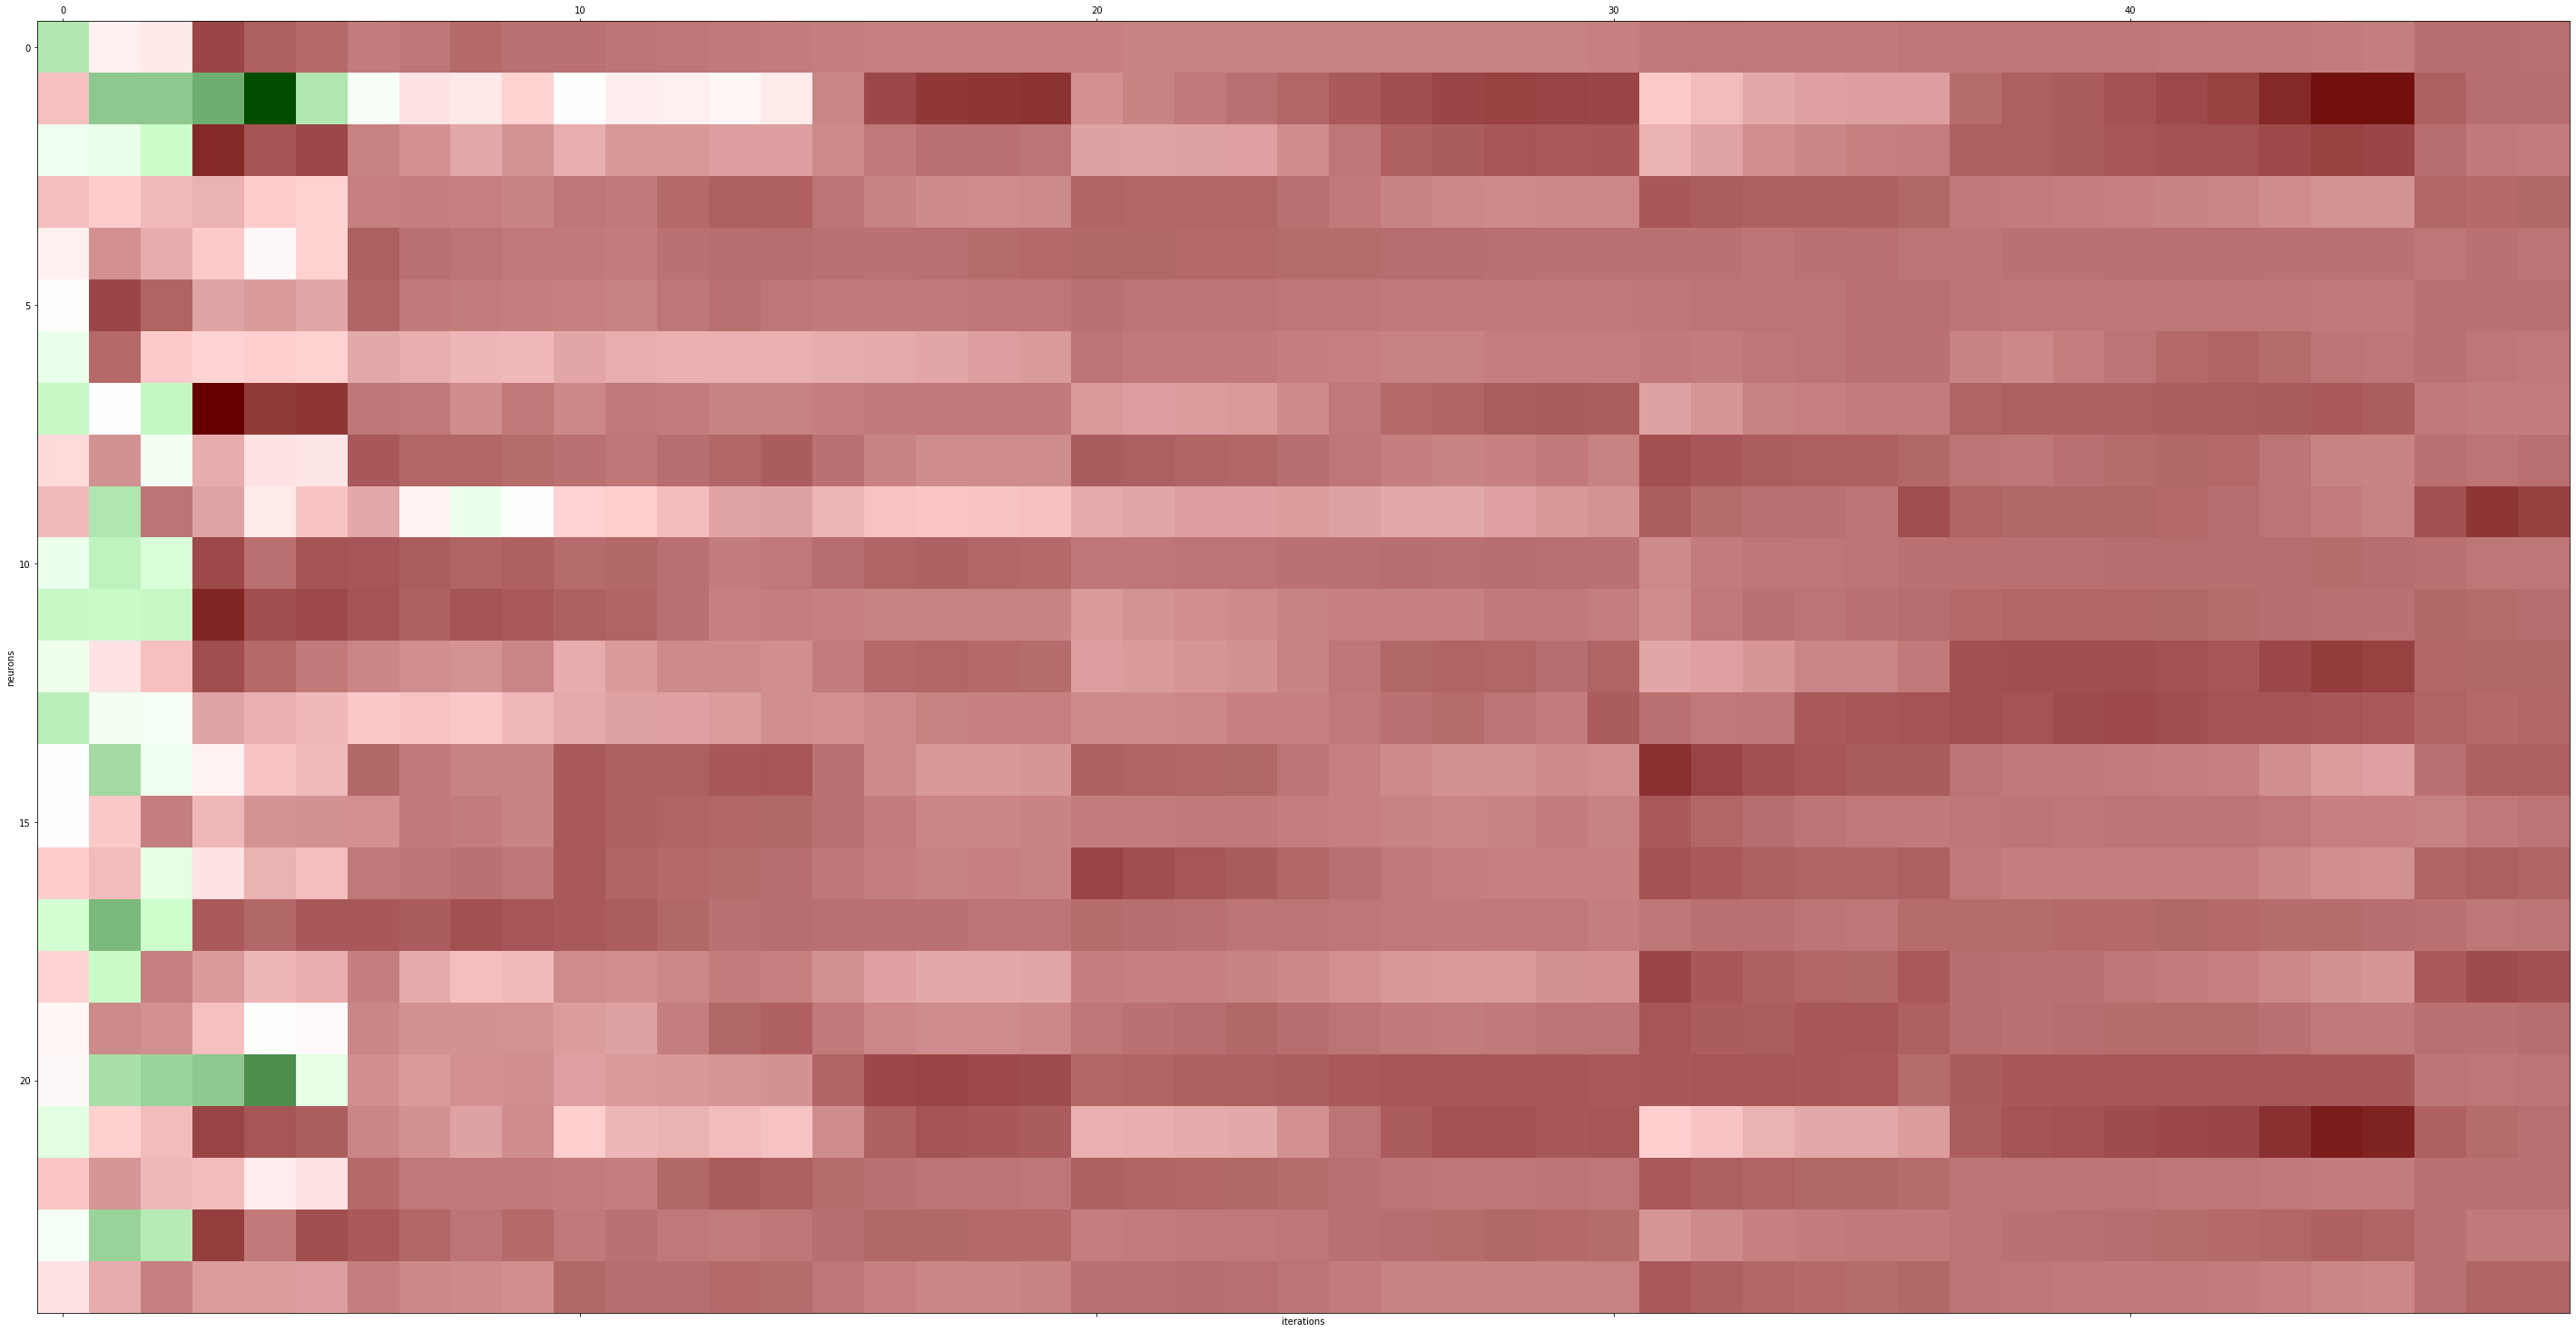

In [0]:
plot_neurons_all_time_revised(lca_per_neuron_2)

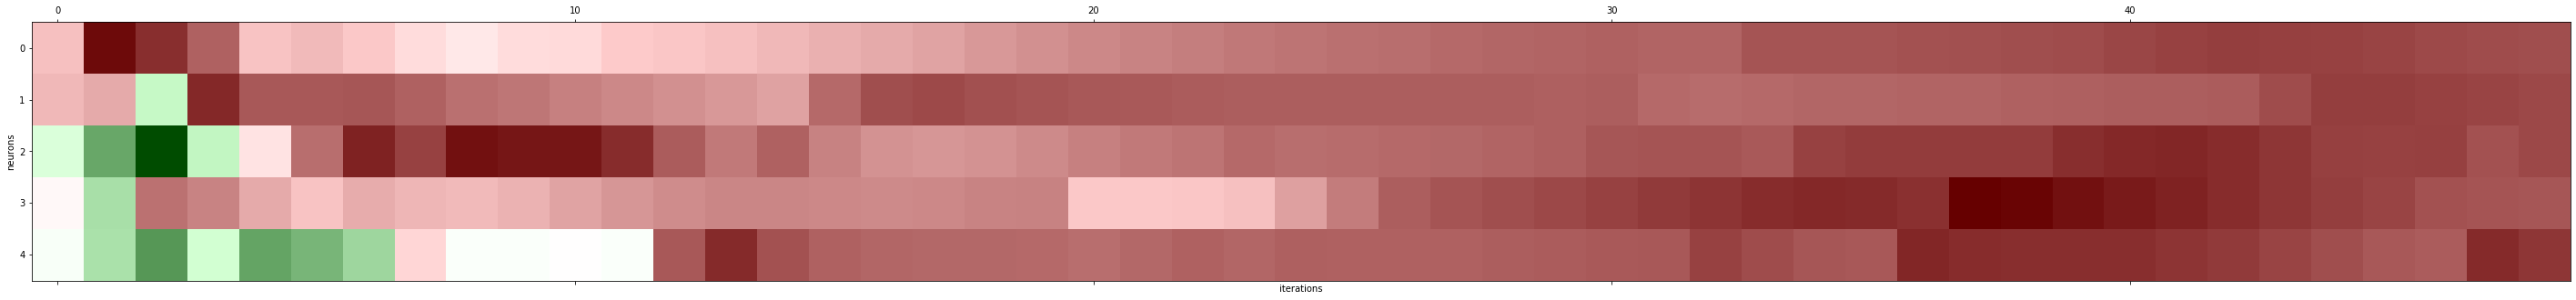

In [0]:
plot_neurons_all_time_revised(lca_per_neuron_out)

In [0]:
# save png's
plot_neurons_all_time_revised(lca_per_neuron_1, plot_dest='/content/lca_per_neuron_layer1')
plot_neurons_all_time_revised(lca_per_neuron_2, plot_dest='/content/lca_per_neuron_layer2')
plot_neurons_all_time_revised(lca_per_neuron_out, plot_dest='/content/lca_per_neuron_layer_out')

### Percent Helped per Iteration

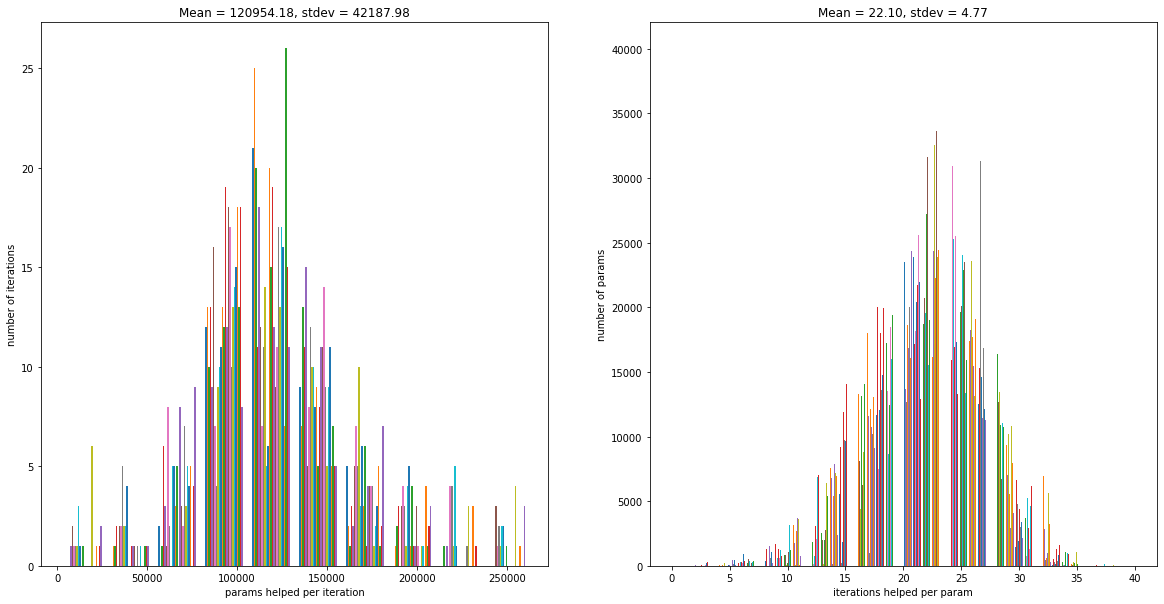

In [0]:
percent_helped_histograms(lca_1)

In [0]:
#Layer 1 params:

params_lca_1 = vector_size * hidden_nodes

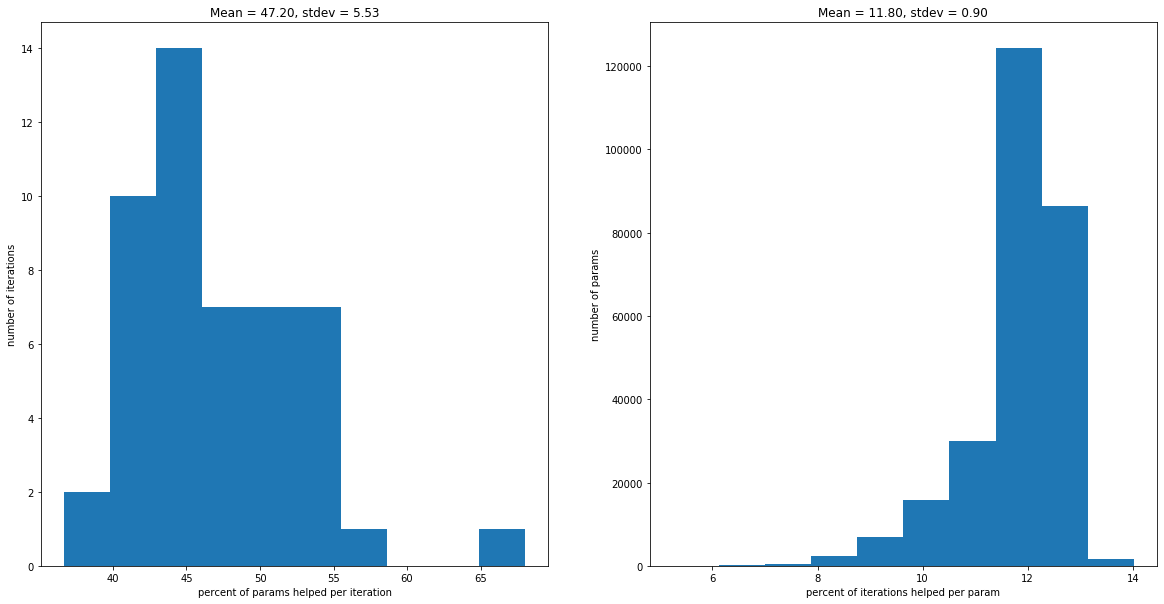

In [0]:
percent_helped_histograms_revised(lca_1, params_lca_1)

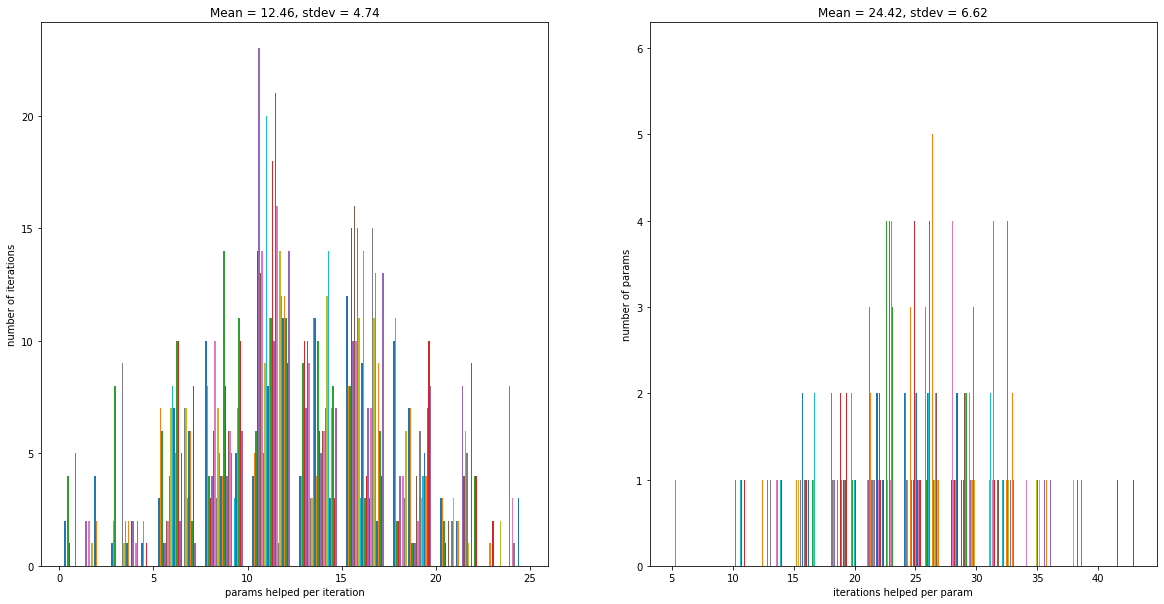

In [0]:
percent_helped_histograms(lca_2)

In [0]:
#Layer 2 params:
params_lca_2 = hidden_nodes * hidden_nodes

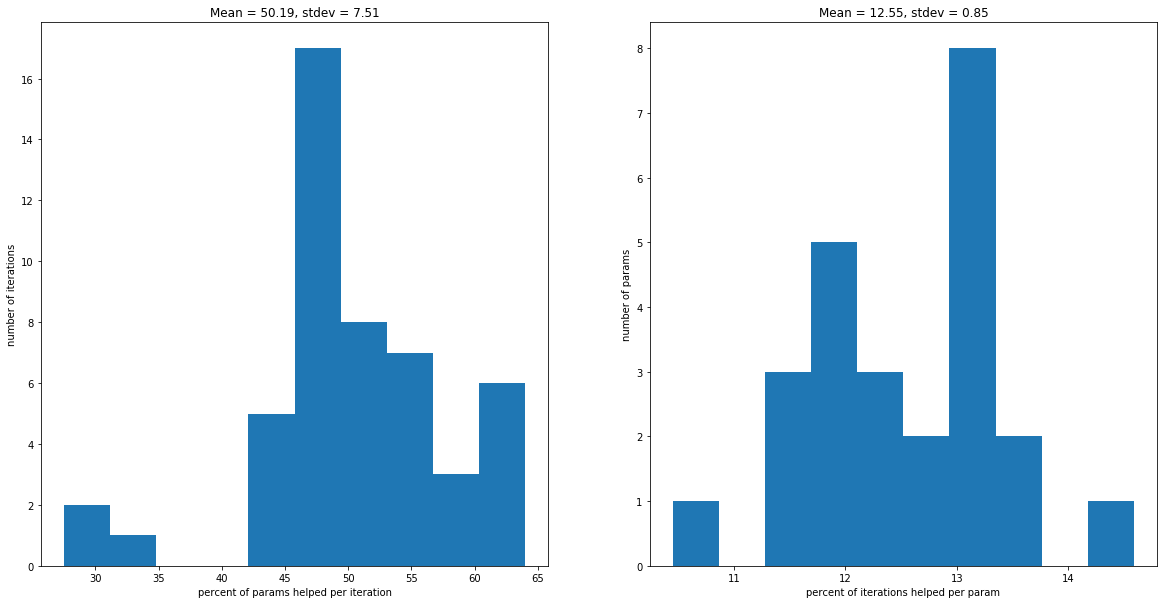

In [0]:
percent_helped_histograms_revised(lca_2, params_lca_2)

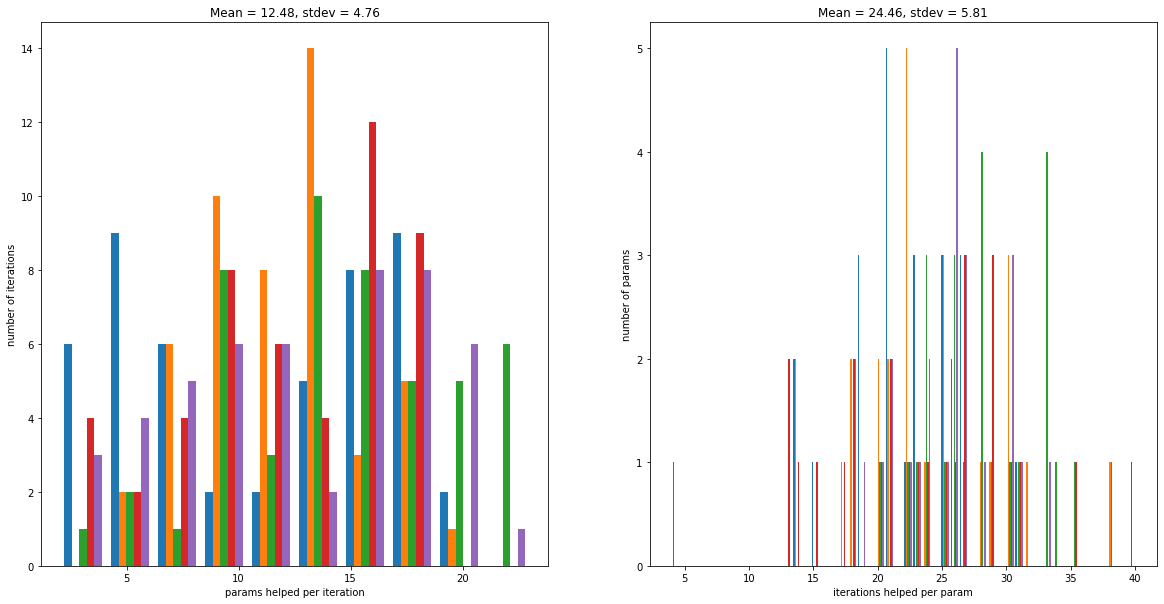

In [0]:
percent_helped_histograms(lca_out)

In [0]:
#Layer out params:

params_lca_out = hidden_nodes * num_classes

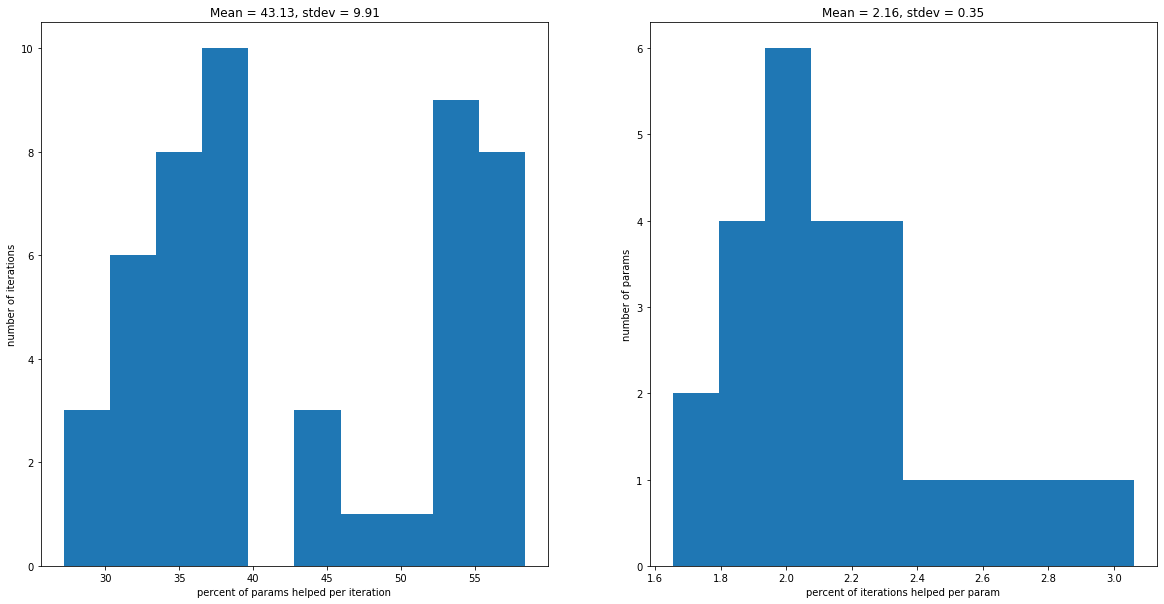

In [0]:
percent_helped_histograms_revised(lca_out, params_lca_out)

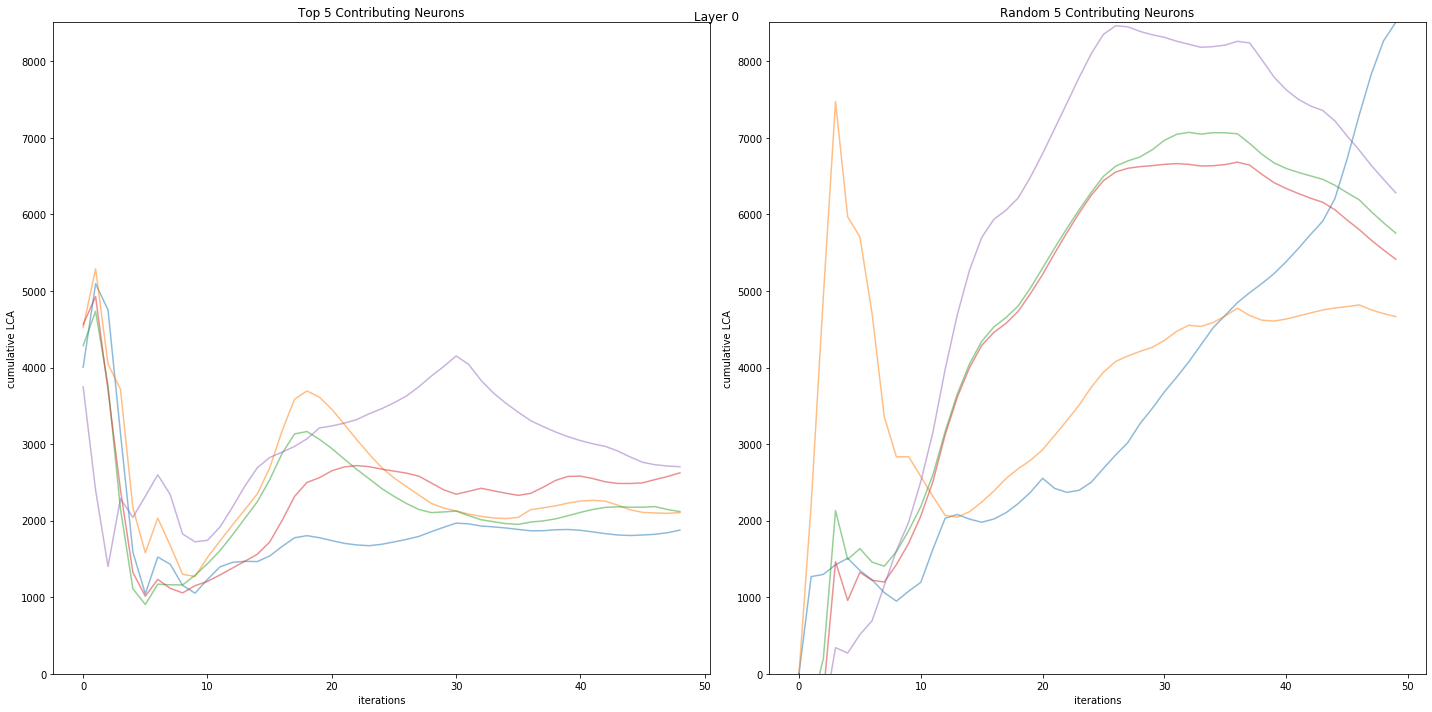

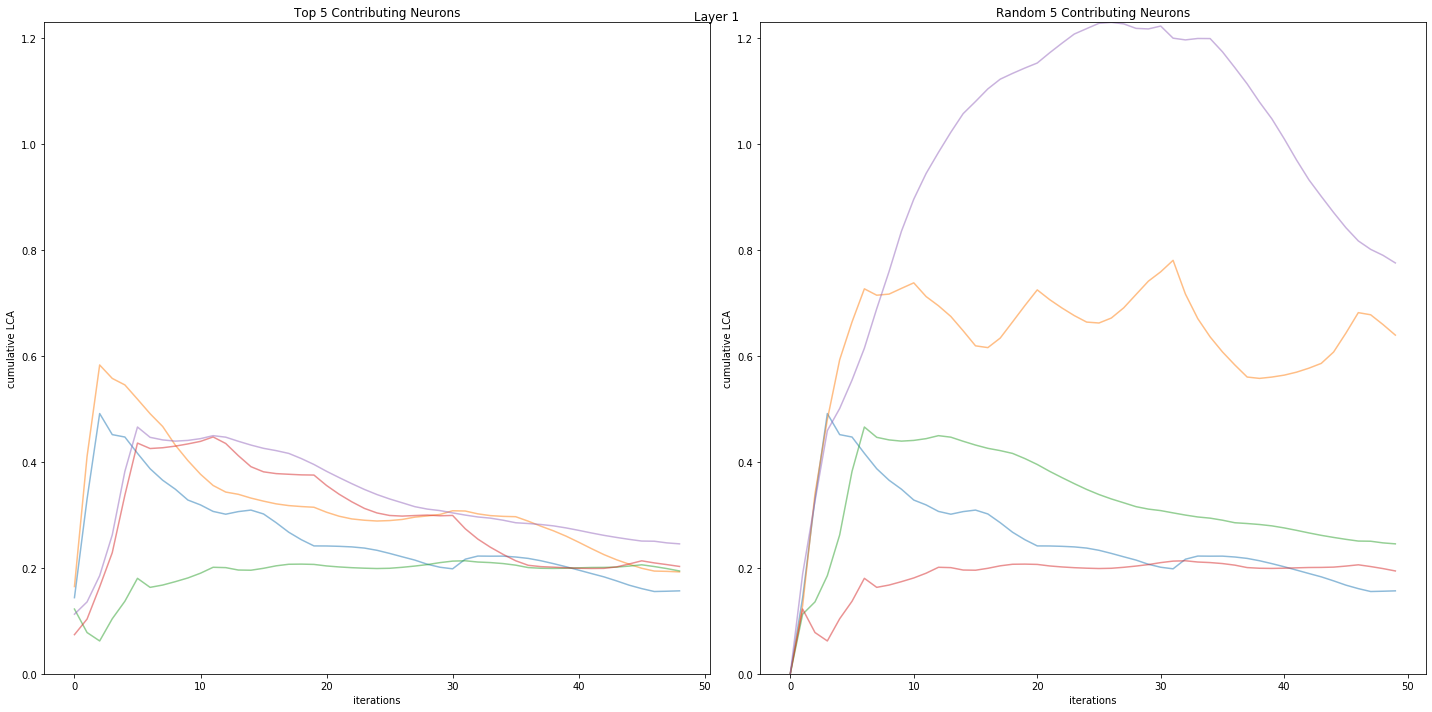

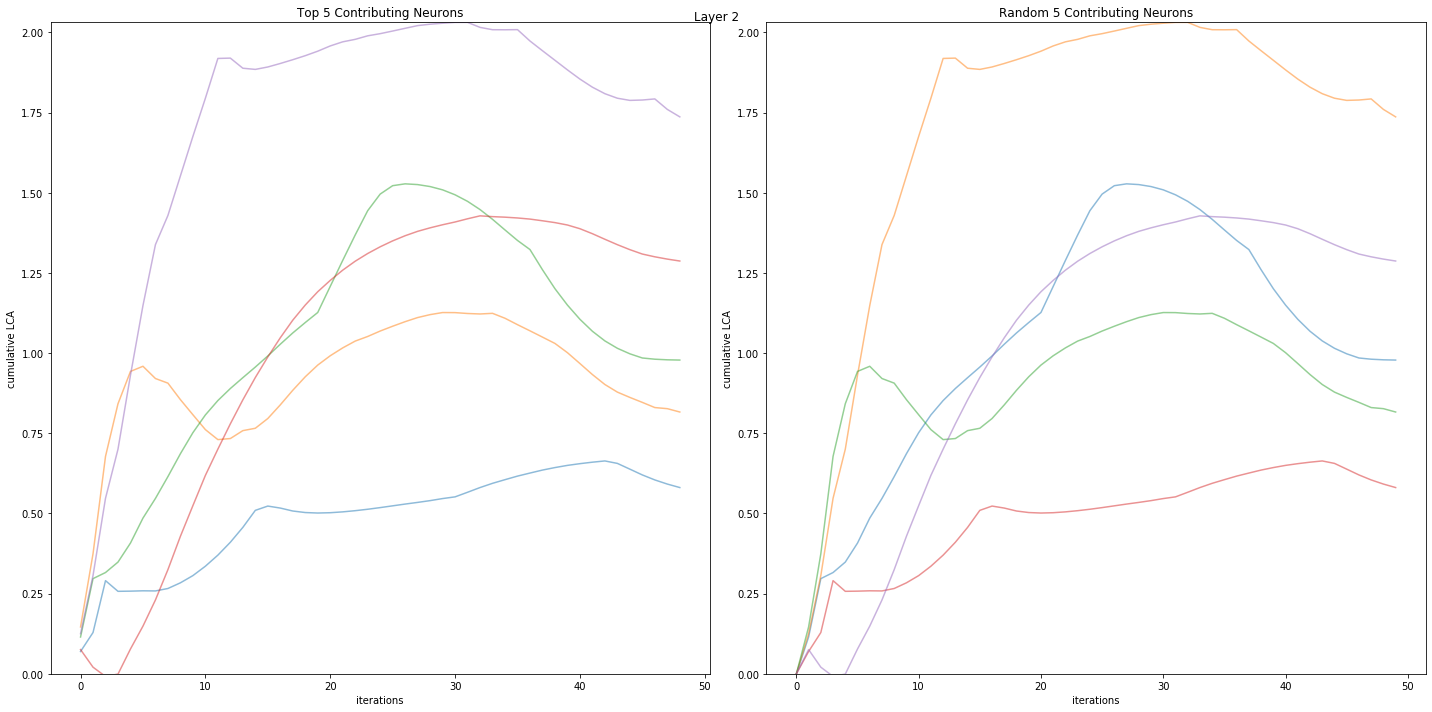

In [0]:
plot_trajectories_per_layer_revised(lca_1, lca_2, lca_out)

In [0]:
# save pngs
plot_trajectories_per_layer_revised(lca_1, lca_2, lca_out, plot_dest = '/content/trajs_per_layer')